# Simple GAN Architecture
[code source](https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f)

In [1]:
import numpy as np
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import random

### Read in Data

In [2]:
F_PATH = Path('img/sketch')  # fake images
R_PATH = Path('img/resize')  # real images

In [3]:
class Dataset(Dataset):
    def __init__(self, real_files, fake_files):
        self.real_files = real_files
        self.fake_files = fake_files
        
    def __len__(self):
        return len(self.real_files)
    
    def __getitem__(self, idx):
        r_path = self.real_files[idx]
        f_path = self.fake_files[idx]  
        
        r_img = cv2.imread(str(r_path)).astype(np.float32)
        f_img = cv2.imread(str(f_path)).astype(np.float32)
        
        # normalize images
        r_img = cv2.cvtColor(r_img, cv2.COLOR_BGR2RGB)/255
        f_img = cv2.cvtColor(f_img, cv2.COLOR_BGR2RGB)/255
        return np.rollaxis(r_img, 2), np.rollaxis(f_img, 2)

In [4]:
real_files = [p for p in R_PATH.iterdir()]
fake_files = [p for p in F_PATH.iterdir()]

# train test split
train = random.sample(range(1000), 800)  
valid = np.setdiff1d(range(1000), train)

In [5]:
train_ds = Dataset(real_files=[real_files[i] for i in train], 
             fake_files=[fake_files[i] for i in train])

valid_ds = Dataset(real_files=[real_files[i] for i in valid], 
             fake_files=[fake_files[i] for i in valid])

In [11]:
batch_size = 1
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

### Architecture

In [12]:
# class MRU(nn.Module):
#     """Implementation of a simple Masked Residual Unit"""
#     def __init__(self, in_channel, out_channel, size):
#         super(MRU, self).__init__()
#         self.conv = nn.Conv2d(in_channel, out_channel, size)
#         self.f = nn.ReLU()
        
#     def forward(self, x):
#         x = self.conv(x)
#         return self.f(x)

In [13]:
# these classes are based on this code 
# https://github.com/milesial/Pytorch-UNet
class Double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        """convolution -> batch norm -> relu (twice)"""
        super(Double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x
    
    
class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            Double_conv(in_ch, out_ch))
    
    def forward(self, x):
        x = self.mpconv(x)
        return x
    
    
class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = Double_conv(in_ch, out_ch)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x
    
    
class U_Net(nn.Module):
    def __init__(self):
        super(U_Net, self).__init__()    
        self.inconv = Double_conv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outconv = Double_conv(64, 3)
        
    def forward(self, x):
        x1 = self.inconv(x)
        
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outconv(x)

In [14]:
class Generator(nn.Module):
    """given some noice, generate a fake image"""
    def __init__(self):
        super(Generator, self).__init__()
        self.unet = U_Net()
        self.f = nn.ReLU()

    def forward(self, x):
        x = self.unet(x)
        return self.f(x)

class Discriminator(nn.Module):
    """given an image, predict if the image is real of fake"""
    def __init__(self):
        super(Discriminator, self).__init__()
        self.map3 = nn.Linear(236592, 1)  # real or not real classification
        self.map1 = nn.Conv2d(3, 6, 15)
        self.map2 = nn.Conv2d(6, 3, 15)
        self.f = nn.Sigmoid()

    def forward(self, x):     
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
       
        x = x.view(x.shape[0], -1)  # cast image to 1 dimension        
        return self.f(self.map3(x))

In [15]:
G = Generator().cuda()
D = Discriminator().cuda()

### Train Discriminator

In [16]:
def val_discriminator():
    """evaluate model on validation set
    return validation loss and validation accuracy"""
    D.eval()
    
    preds = torch.FloatTensor().cuda()
    y_true = torch.FloatTensor().cuda()
    for r, f in valid_dl:
        # generatign fake images
        f = f.cuda()
        r = r.cuda()
        gen_imgs = G(f)
        
        imgs = torch.cat((r, gen_imgs), 0)  # all images
        y = torch.Tensor(np.concatenate((np.ones(r.shape[0], dtype=float), 
                            np.zeros(f.shape[0], dtype=float)), 
                            axis=0)).cuda()
        
        pred = D(imgs)
        preds = torch.cat((preds, pred))
        y_true = torch.cat((y_true, y.unsqueeze(1)))
    
    loss = F.binary_cross_entropy(preds, y_true)
    hard_pred = (preds.cpu() > 0.5).squeeze(1).detach().numpy()

    return loss.item(), accuracy_score(y_true.cpu(), hard_pred)


def train_discriminator(epochs, lr):
    parameters = filter(lambda p: p.requires_grad, D.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    D.train()
    
    for i in range(epochs):
        D.train()
        total_loss = 0
        total = 0
        for r, f in train_dl:
            # generatign fake images
            f = f.cuda()
            r = r.cuda()
            gen_imgs = G(f)
            
            imgs = torch.cat((r, gen_imgs), 0)
            y = torch.Tensor(np.concatenate((np.ones(r.shape[0], dtype=float),  # 1 = real image
                    np.zeros(f.shape[0], dtype=float)),                         # 0 = fake images
                    axis=0)).cuda()
            
            y_hat = D(imgs)
            loss = F.binary_cross_entropy(y_hat, y.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total += imgs.shape[0]
        val_loss, val_accuracy = val_discriminator()
        print(f'Training Loss: {total_loss/total} Valuation Loss {val_loss} Validation Accuracy {val_accuracy}')

In [ ]:
train_discriminator(epochs=5, lr=0.01)

### Train Generator

In [29]:
def train_generator(epochs, lr):
    parameters = filter(lambda p: p.requires_grad, G.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    G.train()
    
    for i in range(epochs):
        G.train()
        total_loss = 0
        total = 0
        for r, f in train_dl:
            # generating fake images
            f = f.cuda()
            r = r.cuda()
            gen_imgs = G(f)
            gen_imgs = gen_imgs.view(f.shape)
            
            # pretend fake images are real
            y = torch.Tensor(np.ones(f.shape[0], dtype=float)).cuda()

            y_hat = D(gen_imgs)
            loss = F.binary_cross_entropy(y_hat, y.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total += gen_imgs.shape[0]
#         val_loss, val_accuracy = val_generator()
        print(f'Training Loss: {total_loss/total}') #' Valuation Loss {val_loss} Validation Accuracy {val_accuracy}')

In [30]:
train_generator(5, 0.01)

Training Loss: 0.8634694218635559
Training Loss: 0.8634694218635559
Training Loss: 0.8634694218635559
Training Loss: 0.8634694218635559
Training Loss: 0.8634694218635559


### Predict

In [33]:
for r, f in valid_dl:
    f = f.cuda()
    r = r.cuda()    
    gen_imgs = G(f)
    gen_imgs = gen_imgs.view(f.shape)

Sketch Image


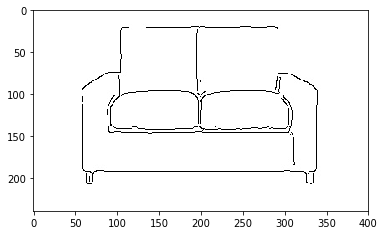

Generated Image


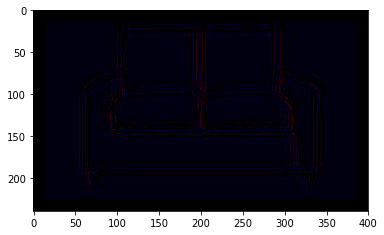

Real Image


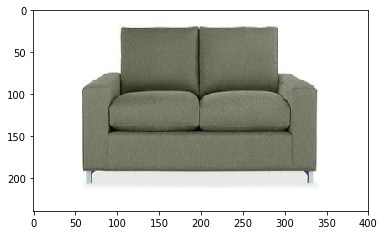

In [37]:
idx = 5 # pick any number between [0,31]

print('Sketch Image')
plt.imshow(np.rollaxis(np.rollaxis(f[idx].cpu().detach().numpy(), 2),2))
plt.show()

print('Generated Image')
plt.imshow(np.rollaxis(np.rollaxis(F.relu(gen_imgs[idx]).cpu().detach().numpy(), 2),2))
plt.show()

print('Real Image')
plt.imshow(np.rollaxis(np.rollaxis(r[idx].cpu().detach().numpy(), 2),2))
plt.show()